In [7]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import SSTDataset
from utils import load_sst_dataset, load_bert_model

%load_ext autoreload
%autoreload 2
sns.set_style('darkgrid')

In [4]:
DATASET_NAME = 'sst'
DATASET_PATH = f'data/{DATASET_NAME}'

OUT_DIR = f'tmp/{DATASET_NAME}'
FEATURES_PATH = f'./{OUT_DIR}/features'
GLM_PATH = f'./{OUT_DIR}/checkpoint'
LIME_PATH = f'./{OUT_DIR}/lime'

MODEL_PATH = 'barissayil/bert-sentiment-analysis-sst' # hugging face

#### Load dataset
___

In [8]:
from utils import load_sst_dataset

dataset, train_loader, test_loader = load_sst_dataset(dataset_path = DATASET_PATH,
                                                      batch_size = 256,
                                                      model_path = MODEL_PATH,
                                                      num_workers = os.cpu_count(),
                                                      return_sentences=False)
class_dict = dataset.label_mapping

#### Load BERT for sentiment classification model
___

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = load_bert_model(MODEL_PATH, device=device)

#### Compute features
___

In [11]:
from feature_helpers import compute_features

feature_loaders, metadata = compute_features(model, 
                                             train_loader, 
                                             test_loader, 
                                             num_classes=dataset.num_classes,
                                             device=device,
                                             out_dir_feats=FEATURES_PATH)

--------- Computing/loading deep features ---------
For train set...
==> loaded 1 files of representations...
Balancing dataset...
For test set...
==> loaded 1 files of representations...
Balancing dataset...


#### Calculating the regularization path
___

Initiliaze linear model

In [12]:
num_classes = dataset.num_classes
num_features = metadata["X"]["num_features"][0]

linear = nn.Linear(num_features, num_classes).to(device)
for p in [linear.weight, linear.bias]: 
    p.data.zero_()

Prepare normalization preprocess and indexed dataloader

In [13]:
from dataset import NormalizedRepresentation

preprocess = NormalizedRepresentation(feature_loaders['train'], 
                                      metadata=metadata, 
                                      device=linear.weight.device)

Calculating the regularization path

In [9]:
from glm_saga.elasticnet import glm_saga 

params = glm_saga(linear, 
                 feature_loaders['train'], 
                 max_lr = 0.1, 
                 nepochs = 2000, 
                 alpha = 0.99, 
                 val_loader=feature_loaders['val'],
                 test_loader=feature_loaders['test'],
                 n_classes=num_classes, 
                 checkpoint=GLM_PATH,
                 verbose = 200, 
                 tol=1e-4, 
                 lookbehind=3, 
                 lr_decay_factor=1,
                 group=True, 
                 epsilon=0.001, 
                 metadata=metadata,
                 preprocess=preprocess)

/home/fabio/.local/lib/python3.7/site-packages/glm_saga/elasticnet.py:324: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  logits = F.softmax(linear(X))


[2021-12-10 17:24:01,501] INFO - obj 0.5275452136993408 weight nnz 0/1536 (0.0000) obj_best 0.5275452136993408
[2021-12-10 17:24:02,634] INFO - obj 0.6229841113090515 weight nnz 0/1536 (0.0000) obj_best 0.5275452136993408 [early stop at 3]
[2021-12-10 17:24:03,492] INFO - (0) lambda 0.8826, loss 0.6922, acc 0.5217 [val acc 0.5217] [test acc 0.5000], sparsity 0.0 [0/1536], time 3.0098440647125244, lr 0.1000
[2021-12-10 17:24:03,841] INFO - obj 0.6230003237724304 weight nnz 0/1536 (0.0000) obj_best 0.6230003237724304
[2021-12-10 17:24:04,917] INFO - obj 0.6229866743087769 weight nnz 0/1536 (0.0000) obj_best 0.6230003237724304 [early stop at 3]
[2021-12-10 17:24:05,777] INFO - (1) lambda 0.8232, loss 0.6922, acc 0.5217 [val acc 0.5217] [test acc 0.5000], sparsity 0.0 [0/1536], time 2.2823150157928467, lr 0.1000
[2021-12-10 17:24:06,148] INFO - obj 0.62298583984375 weight nnz 0/1536 (0.0000) obj_best 0.62298583984375
[2021-12-10 17:24:07,200] INFO - obj 0.6229863166809082 weight nnz 0/1536

#### Load LIME feature explanations
___

Load the dataset with sentences

In [14]:
dataset, train_loader, test_loader = load_sst_dataset(dataset_path = DATASET_PATH,
                                                      batch_size = 256,
                                                      model_path = MODEL_PATH,
                                                      num_workers = os.cpu_count(),
                                                      return_sentences=True)

Generate LIME features

In [ ]:
from feature_helpers import load_features, calculate_metadata
from language_helpers import get_lime_features, top_and_bottom_words

train_feature_path = os.path.join(FEATURES_PATH, 'features_train')
features = load_features(train_feature_path)

loader   = DataLoader(features, batch_size=128)
metadata = calculate_metadata(loader, num_classes=2)
mu,std   = metadata['X']['mean'], metadata['X']['std']

# Generate lime features
get_lime_features(model, dataset, test_loader, LIME_PATH,  mu, std)

Load LIME features

In [7]:
# Load lime files
lime_features = []
lime_files = glob(os.path.join(LIME_PATH, '*'))
for lf in tqdm(lime_files):
    lime_features.append(torch.load(lf))

100%|█████████████████████████████████████████████████████████████████████████████| 1821/1821 [01:18<00:00, 23.23it/s]


Get top words and bot words

In [8]:
from language_helpers import top_and_bottom_words
top_words, bot_words = top_and_bottom_words(lime_features)

#### Load GLM
___

In [3]:
from utils import load_glm
glm_res = load_glm(GLM_PATH)

Loading regularization path of length 101


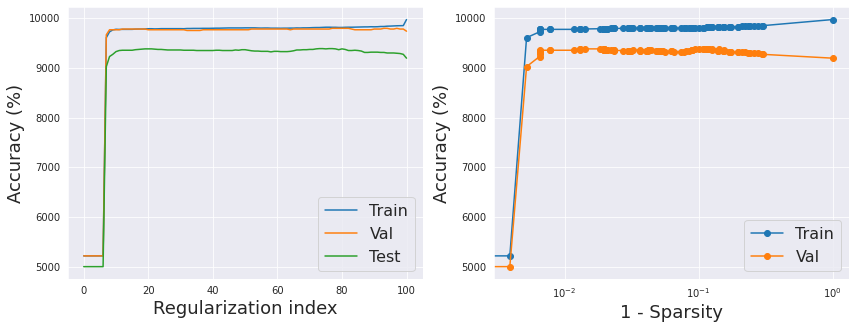

In [9]:
from utils import plot_sparsity
plot_sparsity(glm_res)

In [11]:
from utils import select_sparse_model
CRITERION = 'absolute'
FACTOR = 0.5

glm_res = select_sparse_model(glm_res,
                              selection_criterion=CRITERION,
                              factor=FACTOR)

Test accuracy | Best:  93.89, Sparse: 91.97 Sparsity: 768.00


#### Feature visualization
___

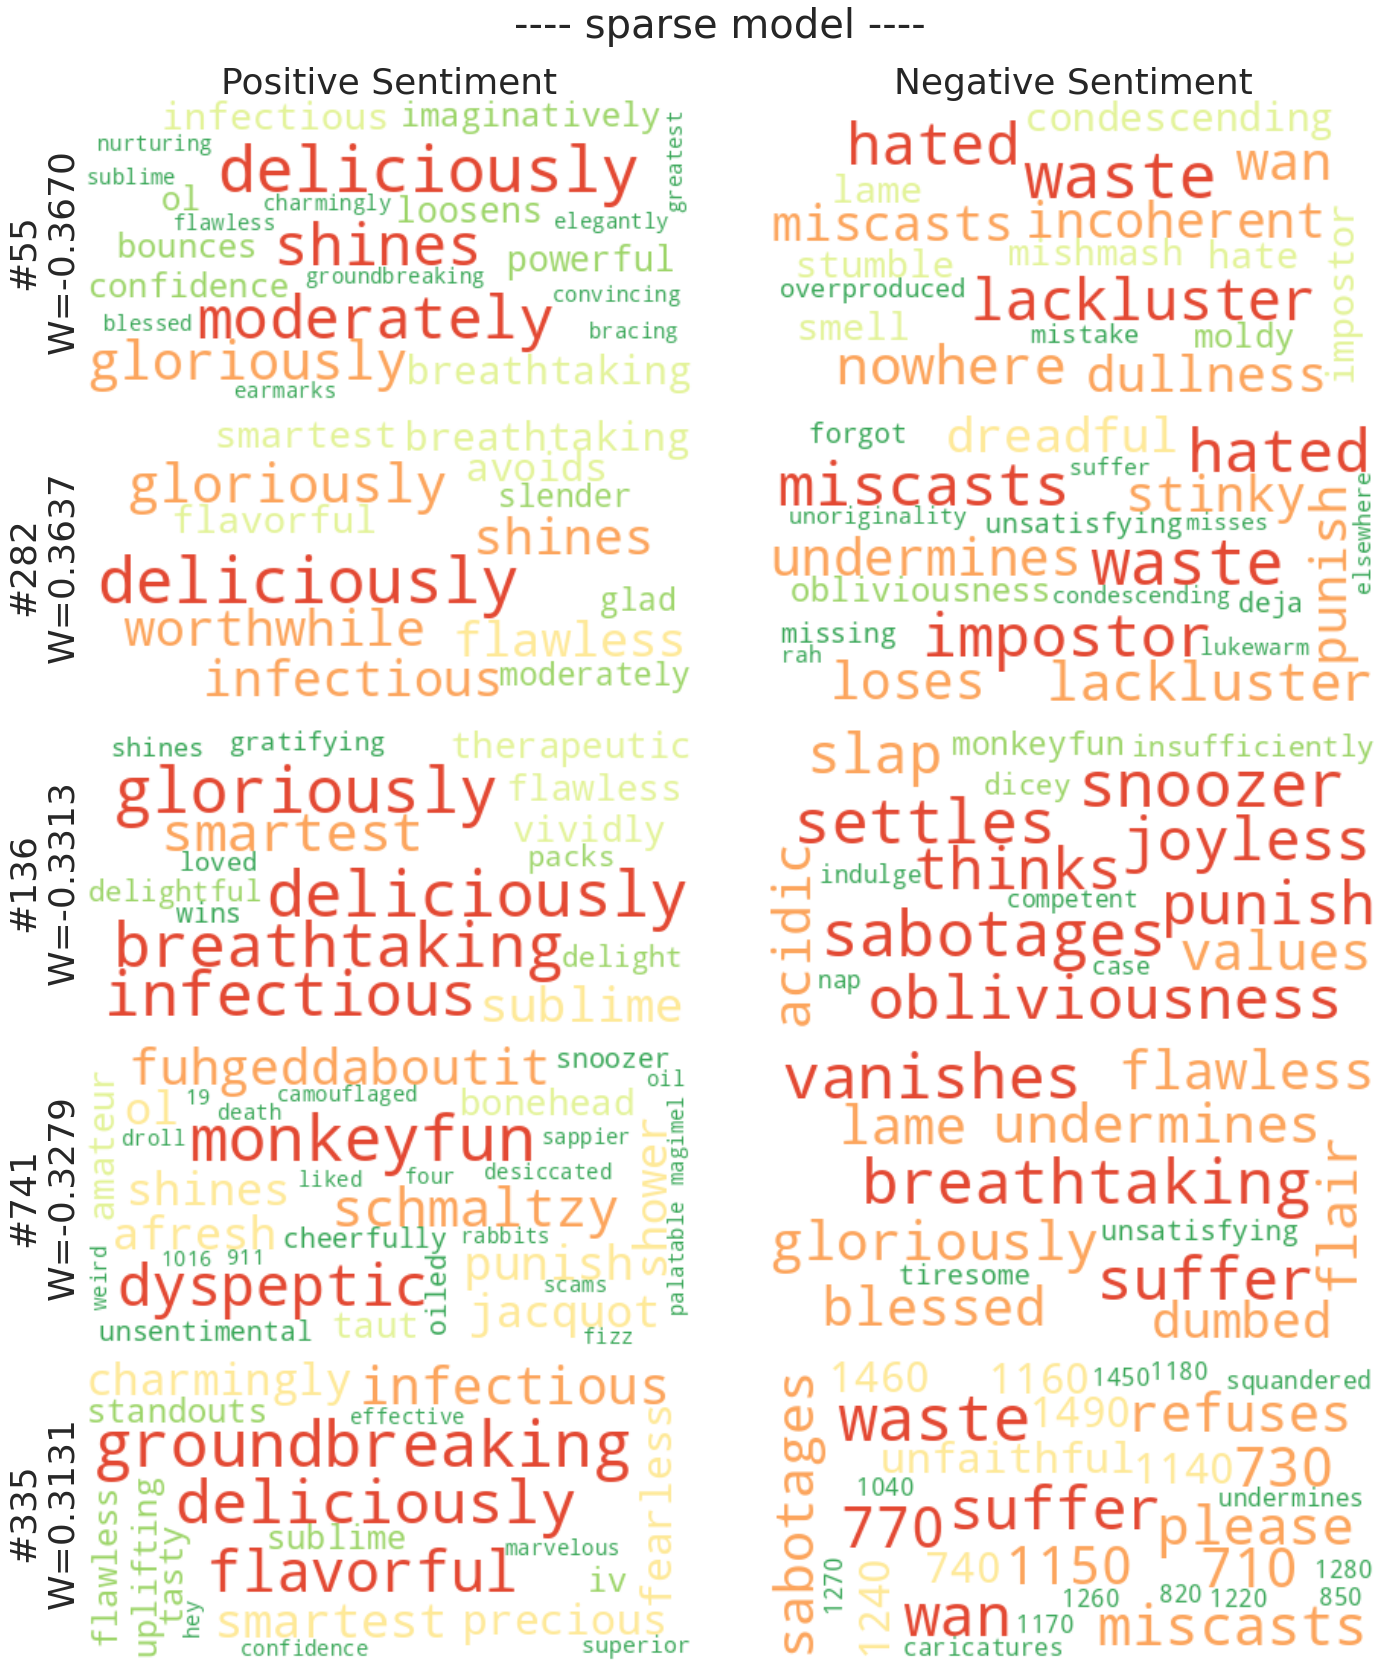

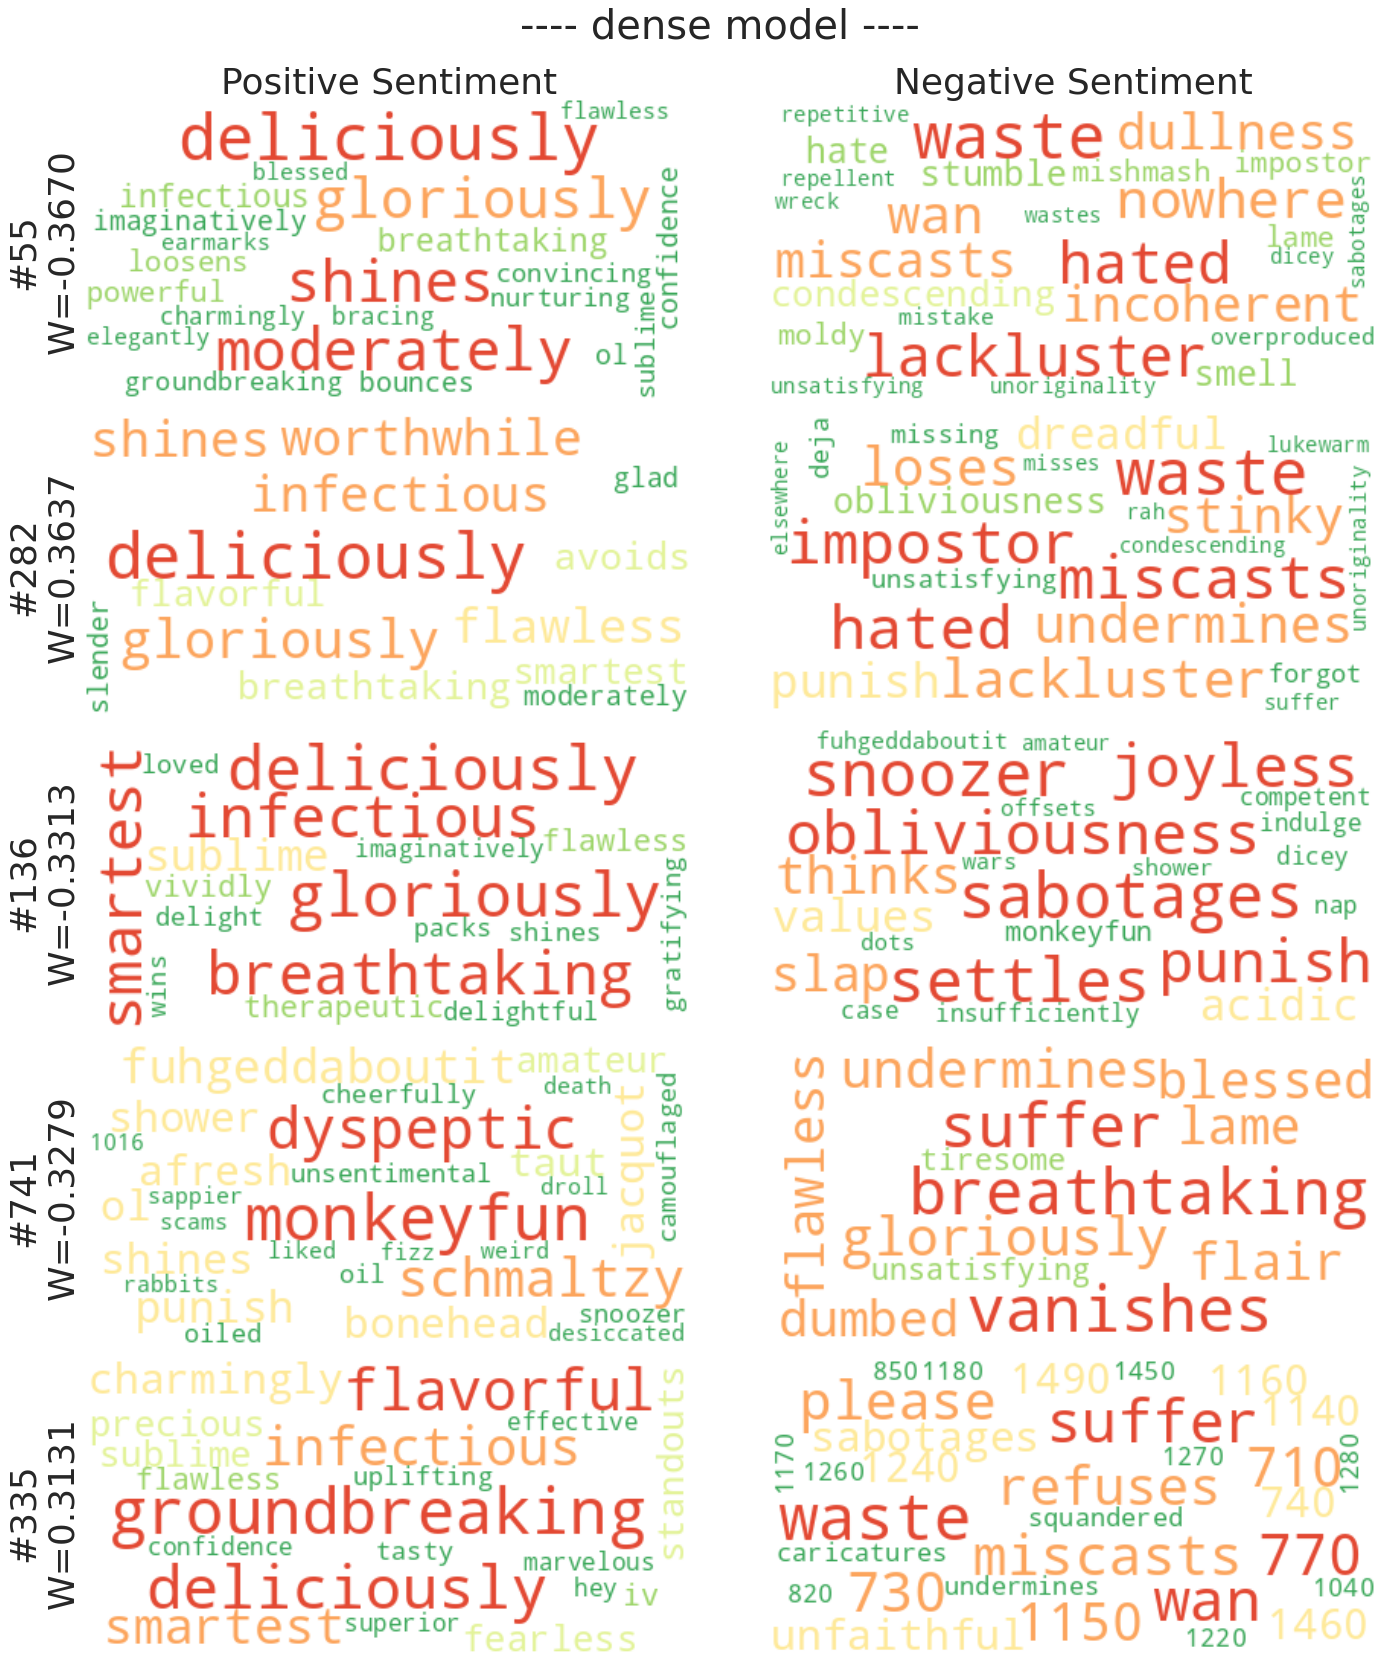

In [13]:
from language_helpers import get_explanations, plot_wordcloud
for name in ['sparse', 'dense']:
    
    model = glm_res[f'weight_{name}']
    labels = ("Positive Sentiment", "Negative Sentiment")

    feature_idxs = list(set(a[1].item() for a in model.nonzero()))
    feature_weights = model.numpy()[1, feature_idxs]

    sidx = np.argsort(-np.abs(feature_weights))
    feature_idxs, feature_weights = np.array(feature_idxs)[sidx], feature_weights[sidx]

    expl_dict = get_explanations(feature_idxs[0:5], model, top_words, bot_words)

    fig, axs = plot_wordcloud(expl_dict, feature_weights, labels=labels)
    fig.suptitle(f'---- {name} model ----', y=1.03, fontsize=40)